## Assignment 1 Euler-Bernoulli's beam

{C1: 0, C2: 0, C3: (L**2*q0 + 2*L*P)/(4*E*I), C4: (-L*q0 - P)/(6*E*I)}

x**2*(6*L*(L*q0 + 2*P) + q0*x**2 - 4*x*(L*q0 + P))/(24*E*I)

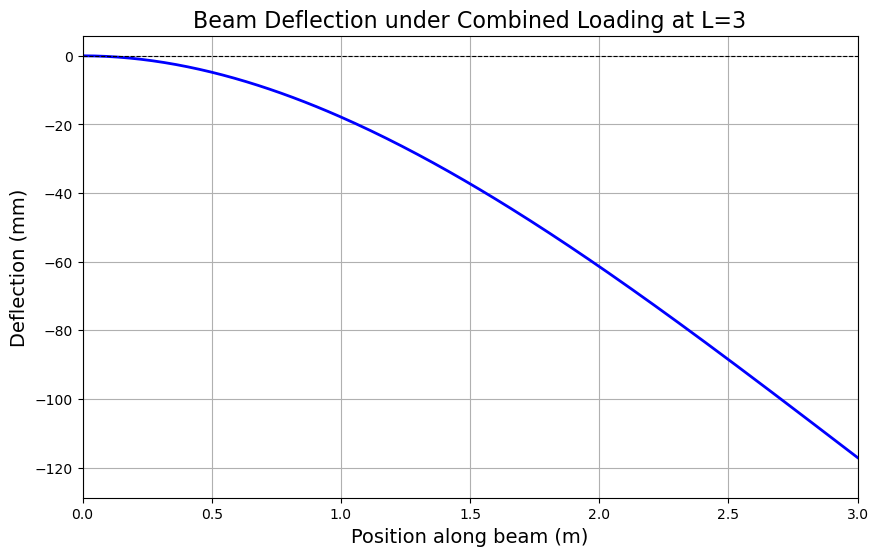

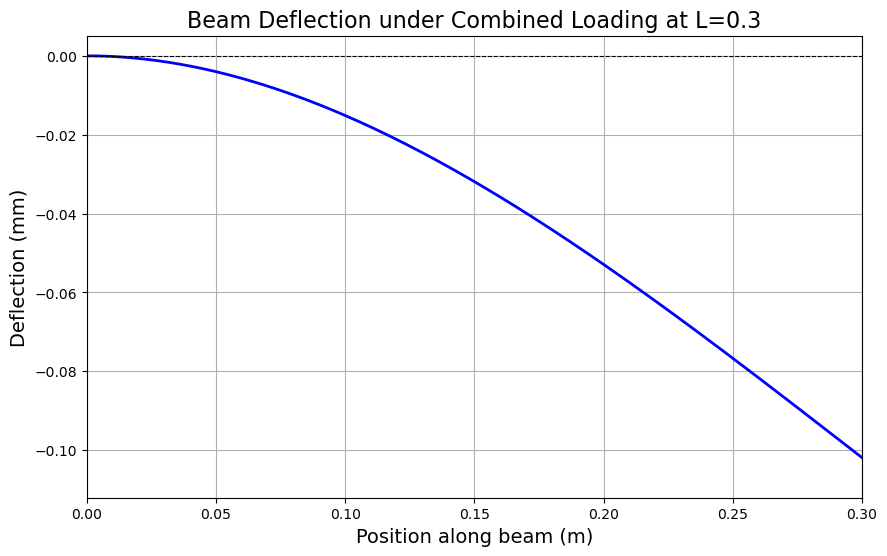

In [12]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

x, L, q0, P, E, I = symbols('x L q0 P E I')

w = Function('w')(x) # w is a function of x

diffeq1 = Eq(E*I * diff(w, x, 4), q0)

w = dsolve(diffeq1, w).rhs

M = -E*I*w.diff(x, 2)

#C1, C2, C3, C4 = symbols('C1 C2 C3 C4')

# Boundary conditions for distributed load
boundary_conditions1 = [ w.subs(x, 0),                      #w(0) = 0
                        w.diff(x).subs(x, 0),                 #w'(0) = 0
                        M.subs(x, L),                       #w''(L) = 0
                        w.diff(x,3).subs(x, L) - P/(-E*I)]      #w'''(L) = -P

integration_constants = solve(boundary_conditions1, 'C1, C2, C3, C4', real=True)

display(integration_constants)

solution = w.subs(integration_constants)

display(simplify(solution))

w_func = lambdify((x, L, q0, P, E, I), solution, 'numpy')

# Numerical values
L1 = 3; L2 = 0.3

L=L1
E=220e9
b=h=0.05
I = b*h**3/12; #moment of inertia
rho = 7800; #density
g = 9.81
m = 130
P = -m*g
poisson = 0.3
q0 = -h*b*rho*g

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()

L=L2


x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=0.3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()


## Timoshenko beam theory

q0*x**4/(24*E*I) + x**3*(-L*q0 - P)/(6*E*I) + x**2*(L**2*q0 + 2*L*P)/(4*E*I) - q0*x**2/(2*A*G*Ks)

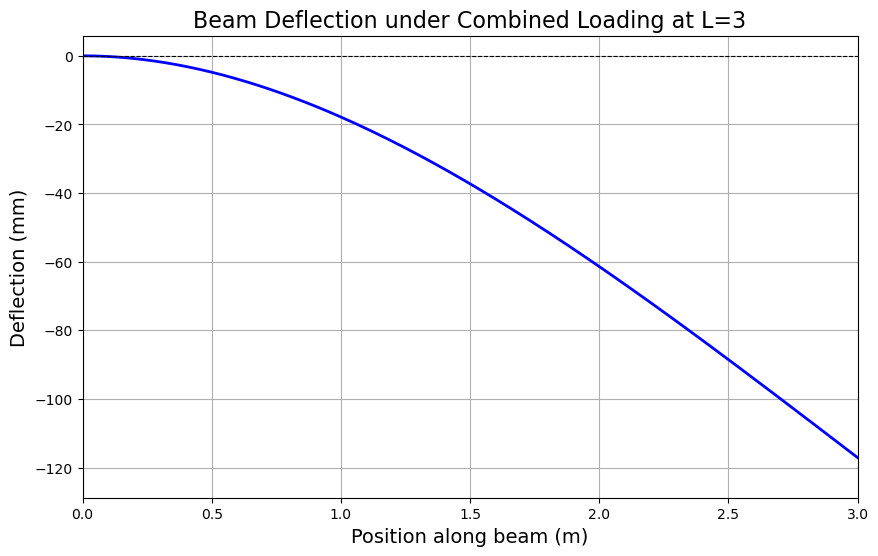

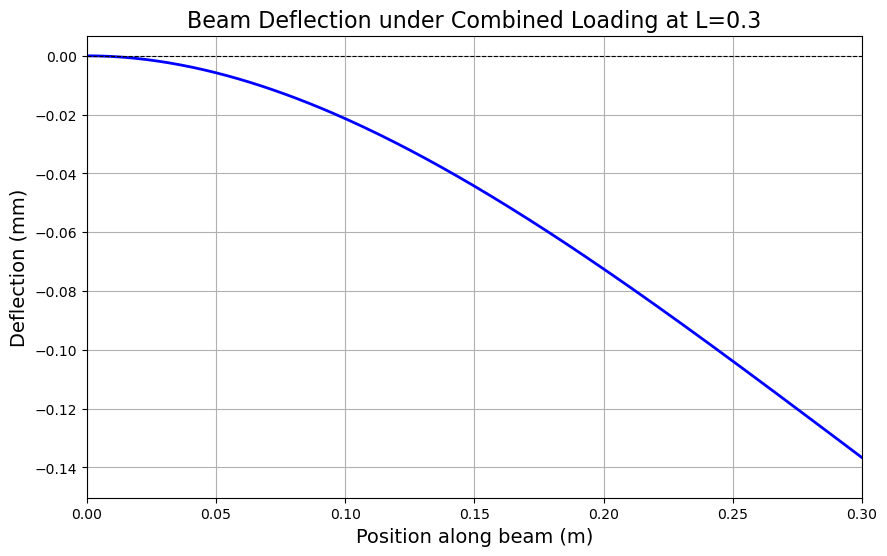

In [19]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

#############
# Poiint load

x, q0, E, I, Ks, G, A, L, P = symbols('x q0 E I Ks G A L P', real=True)

f_phi = Function('phi') # phi is a function of x

## Define the differential equation in terms of phi
diffeq_phi = Eq(E*I*f_phi(x).diff(x, 3), q0)

## Solve the differential equation for phi(x) (eq. 3.35 LN)
phi = dsolve(diffeq_phi, f_phi(x)).rhs

## Solve the differential equation for w(x) (eq. 3.36 LN)
w = Function('w') # w is a function of x
diffeq_w = Eq(w(x).diff(x), -E*I/(G*Ks*A)*phi.diff(x,2) + phi)
w        = dsolve(diffeq_w, w(x)).rhs

## Define boundary conditions
M = -E*I*phi.diff(x)
# Boundary conditions for distributed load
boundary_conditions = [ w.subs(x, 0),                      #w(0) = 0
                        w.diff(x).subs(x, 0),                 #w'(0) = 0
                        M.subs(x, L),                       #w''(L) = 0
                        w.diff(x,3).subs(x, L) - P/(-E*I)]      #w'''(L) = -P

## Solve for the integration constants
integration_constants = solve(boundary_conditions, 'C1, C2, C3, C4', real=True)

## Substitute the integration constants into the solution
solution1 = w.subs(integration_constants)

display(solution1)

w_func = lambdify((x, L, q0, P, E, I, Ks, A, G), solution_total, 'numpy')

# Numerical values
L1 = 3; L2 = 0.3

L=L1
E=220e9
b=h=0.05
I = b*h**3/12; #moment of inertia
rho = 7800; #density
g = 9.81
m = 130
P = -m*g
poisson = 0.3
q0 = -h*b*rho*g
Ks = 5/6
A = b*h
G = E/(2*(1+poisson))    

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I, A, G, Ks)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()


# Numerical values
L1 = 3; L2 = 0.3

L=L2
q0 = -((m*g)/L2)

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I, A, G, Ks)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=0.3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()